Here we use the collection of 3D files to build a training dataset made of temperature profiles, their class and an overlying surface patch of SST and SLA

In [1]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import func

In [2]:
# Load SSH and SLA:
surface = xr.open_dataset('/Users/gmaze/data/DRAKKAR/matlab/NATL12-BATM20/load_GSbox_data0306_SSH.nc')
print surface

<xarray.Dataset>
Dimensions:  (latitude: 254, longitude: 127, time: 292)
Coordinates:
    lat      (latitude, longitude) float64 ...
    lon      (latitude, longitude) float64 ...
    tim      (time) datetime64[ns] ...
Dimensions without coordinates: latitude, longitude, time
Data variables:
    SSH      (time, latitude, longitude) float64 ...
    SLA      (time, latitude, longitude) float64 ...


In [3]:
# Load surface vorticity:
zeta = xr.open_dataset('/Users/gmaze/data/DRAKKAR/matlab/NATL12-BATM20/load_GSbox_data0306_ZETAsurf.nc')
print zeta

<xarray.Dataset>
Dimensions:  (depth: 36, latitude: 254, longitude: 127, time: 291)
Coordinates:
    lat      (longitude, latitude) float64 ...
    lon      (longitude, latitude) float64 ...
    dpt      (depth) float64 ...
    tim      (time) datetime64[ns] ...
Dimensions without coordinates: depth, latitude, longitude, time
Data variables:
    ZETA     (longitude, latitude, time) float64 ...


In [4]:
# Load TEMP and classification results:
# flist = glob.glob('3D/NATL12_iter0*_nobs025_draw001.nc')
flist = glob.glob('3D/NATL12_iter*_nobs025_draw00*.nc')
ds = xr.open_mfdataset(flist, concat_dim='time')
ds

<xarray.Dataset>
Dimensions:      (class: 4, depth: 36, depth_ref: 1, latitude: 254, longitude: 127, n_obs: 25, time: 20)
Coordinates:
  * depth_ref    (depth_ref) float64 -365.9
  * n_obs        (n_obs) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
Dimensions without coordinates: class, depth, latitude, longitude, time
Data variables:
    lon          (time, longitude, latitude) float64 dask.array<shape=(20, 127, 254), chunksize=(1, 127, 254)>
    lat          (time, longitude, latitude) float64 dask.array<shape=(20, 127, 254), chunksize=(1, 127, 254)>
    dpt          (time, depth) float64 dask.array<shape=(20, 36), chunksize=(1, 36)>
    tim          (time) datetime64[ns] dask.array<shape=(20,), chunksize=(1,)>
    clas         (time, class) float64 dask.array<shape=(20, 4), chunksize=(1, 4)>
    temperature  (longitude, latitude, depth, time) float64 dask.array<shape=(127, 254, 36, 20), chunksize=(127, 254, 36, 1)>
    labels       (longitude, latitude, time) float64 dask.ar

In [5]:
# Load Class mean and std profiles:
PCM = pd.read_csv('NATL12_GSbox_PCM_profils.csv',sep=';',header=0).to_xarray()
PCM['dpt'] = xr.DataArray(ds['dpt'].isel(time=0).values, dims='index')
PCM

<xarray.Dataset>
Dimensions:  (index: 36)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    MU1      (index) float64 18.72 18.7 18.67 18.57 18.47 18.37 18.11 17.84 ...
    MU2      (index) float64 22.71 22.68 22.66 22.55 22.41 22.25 22.03 21.75 ...
    MU3      (index) float64 23.55 23.55 23.53 23.53 23.48 23.47 23.43 23.29 ...
    MU4      (index) float64 10.22 10.03 9.996 9.756 9.341 9.008 8.699 8.293 ...
    SI1      (index) float64 4.86 4.821 4.813 4.72 4.617 4.448 4.17 3.859 ...
    SI2      (index) float64 3.53 3.499 3.46 3.389 3.278 3.107 2.942 2.668 ...
    SI3      (index) float64 3.519 3.504 3.499 3.515 3.497 3.464 3.409 3.314 ...
    SI4      (index) float64 5.563 5.156 4.918 4.494 4.016 3.589 3.216 2.813 ...
    dpt      (index) float64 -3.016 -9.148 -15.43 -21.89 -28.56 -35.48 ...

# Select one temperature profile and plot it with surface context

Sample indeces: 18 11 134 42
Time: 2006-04-14T00:00:00.000000000
Latitude: 38.85811996459961
Longitude: -66.54756164550781
1.0


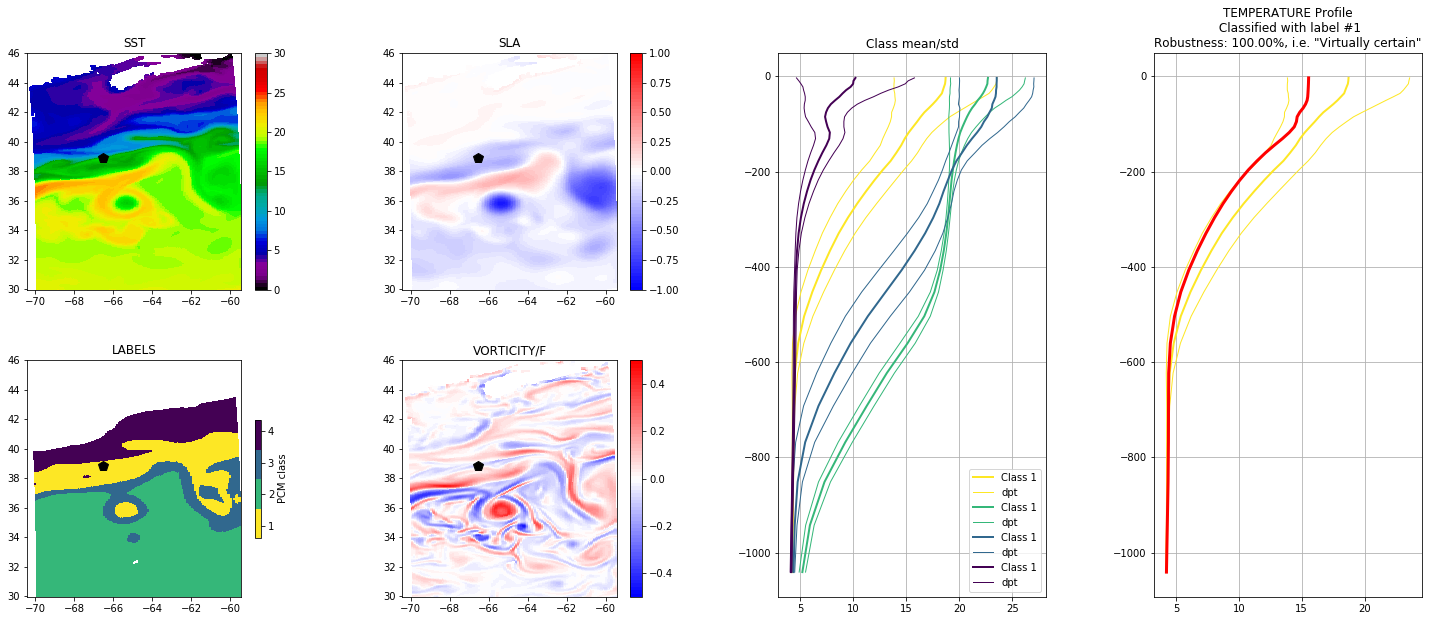

In [11]:
# Select one temperature profile:
iobs = np.random.randint(0,ds['n_obs'].max()-1,1)[0] # Because n_obs is 1-based
itim = np.random.randint(0,ds['time'].max(),1)[0]
ilat = int(ds['obs_ilat'].isel(time=itim).isel(n_obs=iobs).values)-1 # Because obs_ilon is 1-based
ilon = int(ds['obs_ilon'].isel(time=itim).isel(n_obs=iobs).values)-1 # Because obs_ilon is 1-based

print 'Sample indeces:', iobs,itim,ilat,ilon
print 'Time:', ds['tim'].isel(time=itim).values
print 'Latitude:', ds['lat'].isel(time=itim).isel(longitude=ilon).isel(latitude=ilat).values
print 'Longitude:', ds['lon'].isel(time=itim).isel(longitude=ilon).isel(latitude=ilat).values

obs_label = ds['labels'].isel(time=itim).isel(longitude=ilon).isel(latitude=ilat).values
obs_posteriors = ds['posteriors'].isel(time=itim).isel(longitude=ilon).isel(latitude=ilat).values
print 'Label:', obs_label

fig = func.plot_one_profile(surface, zeta, PCM, ds, itim, iobs)

# Now collect the collection of profile with surface patches

In [6]:
# print ds['time'].values
# print ds['n_obs'].values
# print ds['temperature']
nx = ds['longitude'].shape[0]
ny = ds['latitude'].shape[0]
print 'nx,ny: ', nx,ny
i_missed = 0
i_collec = 0
for itim in ds['time'].values:
    for io in ds['n_obs'].values:
        # Locate the synthetic profile on the model grid:
        iobs = int(io)-1
        ilat = int(ds['obs_ilat'].isel(time=itim).isel(n_obs=iobs).values)-1
        ilon = int(ds['obs_ilon'].isel(time=itim).isel(n_obs=iobs).values)-1
#         print 'Sample indeces:', iobs,itim,ilat,ilon
#         print 'Time:', ds['tim'].isel(time=itim).values
#         print 'Latitude:', ds['lat'].isel(time=itim).isel(longitude=ilon).isel(latitude=ilat).values
#         print 'Longitude:', ds['lon'].isel(time=itim).isel(longitude=ilon).isel(latitude=ilat).values
        obs_label = ds['labels'].isel(time=itim).isel(longitude=ilon).isel(latitude=ilat).values

        # Read synthetic temperature profile:
        TEMP = ds['temperature'].isel(time=itim).isel(longitude=ilon).isel(latitude=ilat)
        
        # Collect a patch of horizontal surface data:
        patch_length_lon = 6 # Half zonal length of the patch
        patch_length_lat = 6 # Half meridional length of the patch
        iy = range(ilat-patch_length_lat,ilat+patch_length_lat+1)
        ix = range(ilon-patch_length_lon,ilon+patch_length_lon+1)
        if ((ix[0]<0) | (ix[-1]>nx-1) | (iy[0]<0) | (iy[-1]>ny-1)):            
#             print 'ix:', ix
#             print 'iy:', iy
#             print "Sample too close to boundaries"
            i_missed += 1
        else: # Collecting:
            # Sea Level Anomaly:
            this_time = ds['tim'].isel(time=itim).values
            itim_surface = np.argwhere(surface['tim'].values==this_time)[0][0]
            sla = surface['SLA'].isel(longitude=ix).isel(latitude=iy).isel(time=itim_surface).stack(patch=('latitude', 'longitude'))
            # Sea Surface Temperature:
            sst = ds['temperature'].isel(depth=0).isel(longitude=ix).isel(latitude=iy).isel(time=itim).stack(patch=('latitude', 'longitude'))

            # Save on disk:
            dsout = xr.Dataset()
            dsout.coords['dpt'] = (('depth'), ds['dpt'].isel(time=itim).values)
            dsout['SST'] = sst
            dsout['SLA'] = sla
            dsout['TEMP'] = TEMP
            dsout['LABEL'] = ( ('n_obs',), obs_label[np.newaxis] )
            filename = ("PATCH%03d_NX%i_NY%i.nc")%(i_collec,2*patch_length_lon+1,2*patch_length_lat+1)
            dsout = dsout.unstack('patch')
            dsout.to_netcdf( os.path.join('PATCHES', filename) )
#             fig = func.plot_one_profile(surface, zeta, PCM, ds, itim, iobs)
#             fig.savefig( ("img/PATCH%03d.png")%(i_collec) )
            i_collec += 1

nx,ny:  127 254


In [7]:
# Recollect patches:
dspatch = xr.open_mfdataset('PATCHES/*', concat_dim='n_obs')
# dspatch = dspatch.stack(patch=('latitude', 'longitude'))
# dspatch = dspatch.unstack('patch')

In [8]:
# And save as a single file:
filename = ("ALLPATCHES_NX%i_NY%i.nc")%(2*patch_length_lon+1,2*patch_length_lat+1)
dspatch.to_netcdf( filename )